#Topic Modeling



## Librerias e imports

Antes de nada hay que subir el dataset2 (incluido en el repositorio) al colab, para trabajar con él. Una vez subido comenzar la ejecución

In [0]:
!mkdir datasets
!cp dataset2.json datasets/ 

In [24]:
import numpy as np
import pandas as pd
%pprint

Pretty printing has been turned ON


Para hacer Topic modeling necesitaremos:
* [Spacy](https://spacy.io/) para tokenizar 
* [Stop-Words](https://github.com/Alir3z4/python-stop-words) para tener una lista de palabras que **NO** usar en el topic modeling
* [gensim](https://radimrehurek.com/gensim/) para hacer el topic modelling en si mismo 
* [pyLDAvis](https://github.com/bmabey/pyLDAvis) para visualizar el resultado del topic modeling.

In [25]:
!pip install spacy
!pip install stop_words
!pip install gensim
!pip install pyLDAvis

In [3]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 95.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.1.0-cp36-none-any.whl size=97126237 sha256=09d92fc6403aac4300197847f37903a77176b4f0aedba12aa488dd7f0b9fbf4b
  Stored in directory: /tmp/pip-ephem-wheel-cache-bo__rdyw/wheels/c1/2c/5f/fd7f3ec336bf97b0809c86264d2831c5dfb00fc2e239d1bb01
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
import gensim
from os.path import join
import csv
import spacy
from stop_words import get_stop_words
from string import punctuation
import re
import numpy as np
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import pandas as pd
import io

import warnings
warnings.filterwarnings('ignore')

In [0]:
stop_words = get_stop_words('en') + list(punctuation) + [' ']
nlp = spacy.load('en_core_web_sm')

In [12]:
df = pd.read_json (r'datasets/dataset2.json', orient ='index')
df.head(5)

,label,tweet
0,OBAMA,"“Low plastic stool, cheap but delicious noodle..."
1,OBAMA,"“Low plastic stool, cheap but delicious noodle..."
2,OBAMA,"This National Gun Violence Awareness Day, show..."
3,OBAMA,We can never truly repay the debt we owe our f...
4,OBAMA,This Center is for the leaders of tomorrow who...


##Preparación

### Limpieza del dataset

Usamos el mismo criterio que en el apartado 1 de la practica.

In [0]:
def replace_re (cad, regex, token):
    return re.sub(regex, token, cad)

In [0]:
# quitar espacios antes y despues del texto
df['tweet'] = df['tweet'].map(lambda SentimentText: SentimentText.strip())  

# Cambiar special HTML entities (de http://www.htmlhelp.com/reference/html40/entities/special.html)
#  &amp; 	&lt; 	&gt; &circ; &tilde;
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&amp;', '& '))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&lt;', '<'))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&gt;', '>'))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&circ;', '^'))

# &ensp; &emsp; &thinsp; -> ' '
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&ensp;', ' '))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&thinsp;', ' '))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&emsp;', ' '))

# &ndash; 	&mdash; -> '-'
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&ndash;', '-'))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&mdash;', '-'))

# ' &quot; &lsquo; &rsquo; &sbquo; &ldquo; &rdquo; &bdquo; &lsaquo; &rsaquo;  -> "'"
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('"', "'"))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&quot;', "'"))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&lsquo;', "'"))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&rsquo;', "'"))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&sbquo;', "'"))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&ldquo;', "'"))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&rdquo;', "'"))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&bdquo;', "'"))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&lsaquo;', "'"))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&rsaquo;', "'"))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&quot;', "'"))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('“', "'"))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('”', "'"))
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('’', "'"))

# euro sign	&euro;	&#8364;	&#x20AC;	€	€	€
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('&euro;', '€'))

# quitar /n
escape_char_re = r'\n|\t'
df['tweet'] = df['tweet'].apply(lambda x: replace_re(x, escape_char_re, ""))

# quitar @username (mentions)
twitterHandle_re = r'(^|[^@\w])@(\w{1,15})\b'
df['tweet'] = df['tweet'].apply(lambda x: replace_re(x, twitterHandle_re, "")) 

# hashtag 
# no los quito porque pueden dar topics
# hashtag_re = r'(?:^|\s|\')[＃#]{1}(\w+)'
# df['tweet'] = df['tweet'].apply(lambda x: replace_re(x, hashtag_re, "<HASHTAG>")) 

# quitar urls
url_re = r'[localhost|http|https|ftp|file]+://[\w\S(\.|:|/)]+'
df['tweet'] = df['tweet'].apply(lambda x: replace_re(x, url_re, "")) 

# quitar espacios multiples en la cadena 'The    quick  lazy    fox'->'The quick lazy fox' 
extraSpaces_re = r' +'
df['tweet'] = df['tweet'].apply(lambda x: replace_re(x, extraSpaces_re, " "))

# quitar espacios antes y despues del texto (los que se hayan podido meter despues de las sustituciones)
df['tweet'] = df['tweet'].map(lambda tweet: tweet.strip())  

In [16]:
print(df.head(5))
df.shape

   label                                              tweet
0  OBAMA  'Low plastic stool, cheap but delicious noodle...
1  OBAMA  'Low plastic stool, cheap but delicious noodle...
2  OBAMA  This National Gun Violence Awareness Day, show...
3  OBAMA  We can never truly repay the debt we owe our f...
4  OBAMA  This Center is for the leaders of tomorrow who...


(5889, 2)

Vemos que hay datos repetidos, los eliminamos.

In [17]:
df = df.drop_duplicates()
df.shape

(5681, 2)

Con el dataframe ya limpio, pasamos a generar documentos, lo que no deja de ser más que una lista de listas de palabra.

In [0]:
documents = []

In [0]:
for row in df.iterrows():
    _, tweets = row
    _, tweet = tweets    
    
    tweet = [t.text for t in nlp(tweet.rstrip(), disable=['parser', 'tagger', 'ner']) if t.text not in stop_words]
    
    documents.append(tweet)   

In [28]:
documents[0:1]

[['Low',
  'plastic',
  'stool',
  'cheap',
  'delicious',
  'noodles',
  'cold',
  'Hanoi',
  'beer',
  'This',
  'I',
  "'ll",
  'remember',
  'Tony',
  'He',
  'taught',
  'us',
  'food',
  '—',
  'importantly',
  'ability',
  'bring',
  'us',
  'together',
  'To',
  'make',
  'us',
  'little',
  'less',
  'afraid',
  'unknown',
  'We',
  "'ll",
  'miss']]

LA solución inicial requeriría crear un set con todas las palabras de todos los documentos y creamos un indice directo e inverso

In [29]:
#dictionary building manually as always
vocab = set([t for doc in documents for t in doc])
w2id = {k:i for  i,k in enumerate(vocab)}
id2w = {i:k for k, i in w2id.items()}
print('{} unique tokens'.format(len(w2id)))

10335 unique tokens


In [0]:
!mkdir results

In [0]:
token_df = pd.DataFrame.from_dict(w2id, orient='index',)
token_df.to_csv('results/tokens.csv')

Pero para que reinventar la rueda... podemos usar directamnte gensim

In [0]:
# Use already built functions for this, same effect as manually building it
from gensim.corpora import Dictionary

In [39]:
gensim_dict = Dictionary(documents)
#
len(gensim_dict)

10335

Eliminamos toda palabra que esté menos de dos veces y que esté en el 30% más nombrado

In [0]:
gensim_dict.filter_extremes(no_below=2, no_above=0.3)

In [44]:
len(gensim_dict)

5425

Y sacamos un Bag Of Words de los mismos

In [0]:
corpus = [gensim_dict.doc2bow(doc) for doc in documents]

In [0]:
#build a model
from gensim import corpora, models, similarities

In [0]:
lda_mid = models.LdaModel(corpus, id2word=gensim_dict, num_topics=20, iterations=5, passes=20, alpha='auto')

### Primera aproximación a la visualización

Hago una primera visualización para poder hacer una aproximación.

In [48]:
vis = pyLDAvis.gensim.prepare(lda_mid, corpus, gensim_dict)
pyLDAvis.display(vis)

### Segunda limpieza


Después de una primera iteración con el cuaderno, veo "palabras" en el diccionario que no son realmente palabras, por ejemplo '—', asi que limpio el dataset de estas, emojis...
 

In [0]:
df['tweet'] = df['tweet'].map(lambda tweet: tweet.replace('—', " "))

#emoji regex de # http://stackoverflow.com/a/13752628/6762004
emoji_re = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)

df['tweet'] = df['tweet'].apply(lambda x: replace_re(x, emoji_re, ""))

In [0]:
# quitar espacios multiples en la cadena 'The    quick  lazy    fox'->'The quick lazy fox' 
extraSpaces_re = r' +'
df['tweet'] = df['tweet'].apply(lambda x: replace_re(x, extraSpaces_re, " "))

Tambien considero que los temas de los que habla cada uno de los presidentes son distintos, con lo que para analizarlo mejor voy a generar documentos distintos para cada uno de ellos.

## Generación y Visualización de Topics

In [0]:
documents = []

In [0]:
documents_obama = []
documents_trump  = []

In [0]:
for row in df.iterrows():
    _, tweets = row
    label, tweet = tweets    
    tweet = [t.text for t in nlp(tweet.rstrip(), disable=['parser', 'tagger', 'ner']) if t.text not in stop_words]
    
    documents.append(tweet)
    if label == 'OBAMA':
        documents_obama.append(tweet)
    else:
        documents_trump.append(tweet)        

In [56]:
gensim_dict = Dictionary(documents)
gensim_dict_obama = Dictionary(documents_obama)
gensim_dict_trump = Dictionary(documents_trump)

gensim_dict.filter_extremes(no_below=2, no_above=0.3)
gensim_dict_obama.filter_extremes(no_below=2, no_above=0.3)
gensim_dict_trump.filter_extremes(no_below=2, no_above=0.3)

print(len(gensim_dict), len(gensim_dict_obama), len(gensim_dict_trump))

5399 2242 4143


In [0]:
corpus = [gensim_dict.doc2bow(doc) for doc in documents]
corpus_obama = [gensim_dict_obama.doc2bow(doc) for doc in documents_obama]
corpus_trump = [gensim_dict_trump.doc2bow(doc) for doc in documents_trump]

Tenemos que elegir cual es el numero correcto de topics para cada presidente y para todo el dataset.

In [0]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, iterations=5, passes=20, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
def calcula_num_topics(diccionario, corpus_usado, documentos, name='', limit=40, start=2, steps=2):
    model_list, coherence_values = compute_coherence_values(dictionary=diccionario, corpus=corpus_usado, texts=documentos, start=start, limit=limit, step=steps)
    x = range(start, limit, steps)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics\n"+name)
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

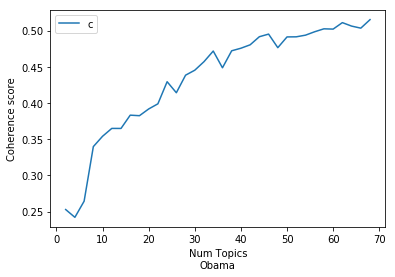

In [62]:
calcula_num_topics(gensim_dict_obama, corpus_obama, documents_obama, 'Obama', limit=70)

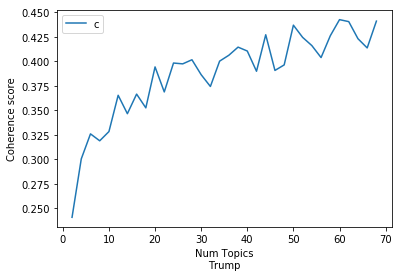

In [63]:
calcula_num_topics(gensim_dict_trump, corpus_trump, documents_trump, 'Trump', limit=70)

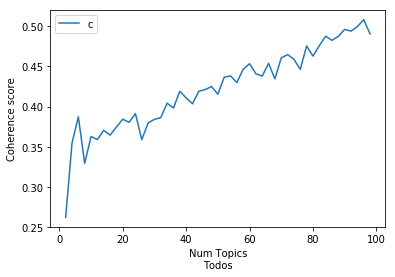

In [64]:
calcula_num_topics(gensim_dict, corpus, documents, 'Todos', limit=100)

En todos los casos vemos como la coherencia de cada tópic aumenta segun aumentan el número de topics. Si elegimos un número muy alto de tópics, la visialización se resiente mucho, ya que se convierte en un maremagnum de circulos interconectados, que no permiten ver gran cosa. Por contra si este parámetro es muy bajo, la coherencia de estos topics es baja.

Así pues establecemos un compromiso y recalculamos los modelos para luego visualizarlos.

Con los valores optimos de numero de topis para optimizar la calidad de la información, recalculamos los modelos 

In [0]:
num_topics_obama = 34
num_topics_trump = 22
num_topics_todos = 24

Y la visualizamos para cada número de de topics

In [0]:
lda_obama = models.LdaModel(corpus_obama, id2word=gensim_dict_obama, num_topics=num_topics_obama, iterations=5, passes=20, alpha='auto')
vis_obama = pyLDAvis.gensim.prepare(lda_obama, corpus_obama, gensim_dict_obama)

lda_trump = models.LdaModel(corpus_trump, id2word=gensim_dict_trump, num_topics=num_topics_trump, iterations=5, passes=20, alpha='auto')
vis_trump = pyLDAvis.gensim.prepare(lda_trump, corpus_trump, gensim_dict_trump)

lda_todos = models.LdaModel(corpus, id2word=gensim_dict, num_topics=num_topics_todos, iterations=5, passes=20, alpha='auto')
vis_todos = pyLDAvis.gensim.prepare(lda_todos, corpus, gensim_dict)

### Topics de Obama

In [67]:
pyLDAvis.display(vis_obama)

### Topics de Trump

In [68]:
pyLDAvis.display(vis_trump)

### Topics del Dataset entero

In [69]:
pyLDAvis.display(vis_todos)